# Getting and Visualizing Stock Data
(from https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/)

In [3]:
import pandas as pd
import pandas.io.data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime

import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


## Overview

Today, we'll be covering a few things:

1. Taking a dataset and visualizing stock prices
2. Doing a moving average (smoothing) filter for stock prices

Most of this will be straight from Curtis Miller's blog post at 
https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/. So if you want a better formatted version, go there.

Let's first grab some stock data:

In [5]:
# Let's set a date range of stuff we want to do
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# We'll use Google as our company
google = web.DataReader("GOOG", "yahoo", start, end)
print(type(google))

<class 'pandas.core.frame.DataFrame'>


Now, let's take a look at the data and the parameters we have:

In [6]:
google.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,743.000000,744.059998,731.257996,741.840027,3272800,741.840027
2016-01-05,746.450012,752.000000,738.640015,742.580017,1950700,742.580017
2016-01-06,730.000000,747.179993,728.919983,743.619995,1947000,743.619995
2016-01-07,730.309998,738.500000,719.059998,726.390015,2963700,726.390015
2016-01-08,731.450012,733.229980,713.000000,714.469971,2450900,714.469971


Let’s briefly discuss this. Open is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), high is the highest price of the stock on that trading day, low the lowest price of the stock on that trading day, and close the price of the stock at closing time. Volume indicates how many stocks were traded. Adjusted close is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.

## Visualizing Stock Data

Now that we have stock data we would like to visualize it. I first demonstrate how to do so using the matplotlib package. Notice that the apple DataFrame object has a convenience method, plot(), which makes creating plots easier.

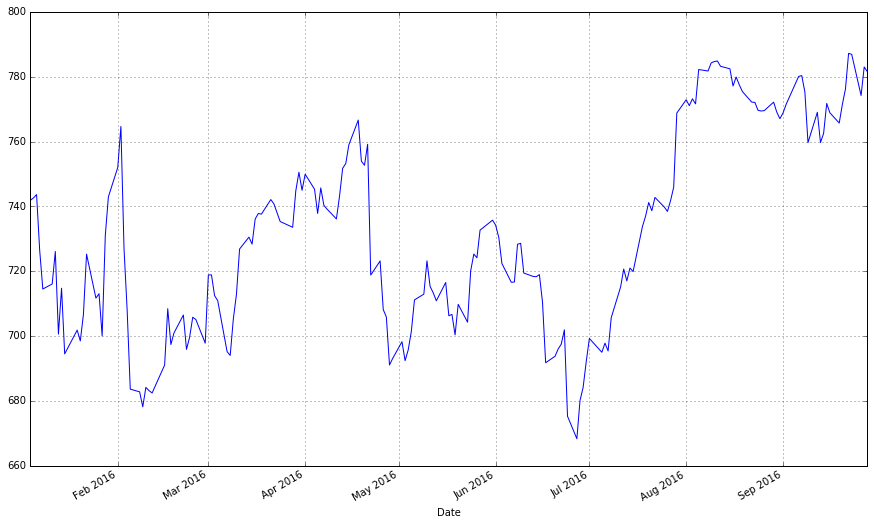

In [7]:
google["Adj Close"].plot(grid = True)

A linechart is fine, but there are at least four variables involved for each date (open, high, low, and close), and we would like to have some visual way to see all four variables that does not require plotting four separate lines. Financial data is often plotted with a Japanese candlestick plot, so named because it was first created by 18th century Japanese rice traders. Such a chart can be created with matplotlib, though it requires considerable effort.

I have made a function you are welcome to use to more easily create candlestick charts from pandas data frames, and use it to plot our stock data. (Code is based off [this](http://matplotlib.org/examples/pylab_examples/finance_demo.html) example, and you can read the documentation for the functions involved [here](http://matplotlib.org/api/finance_api.html).)

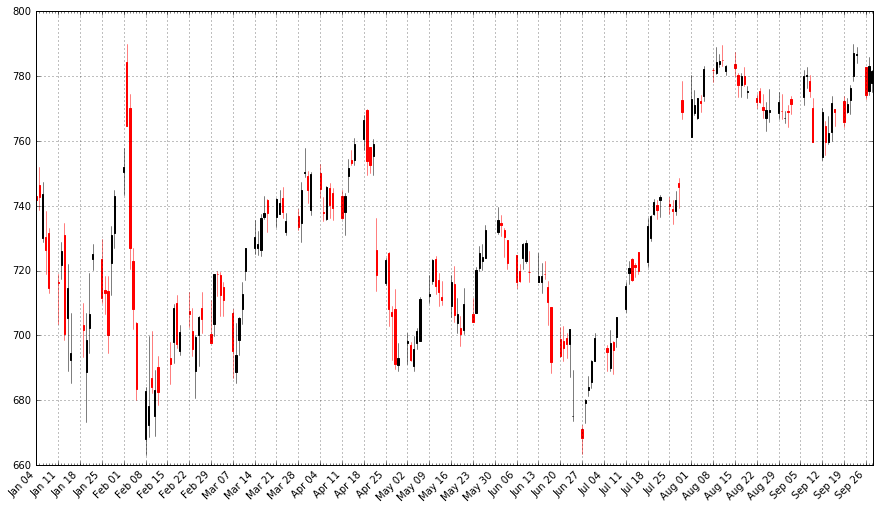

In [8]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(google)

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close). Candlestick charts are popular in finance and some strategies in technical analysis use them to make trading decisions, depending on the shape, color, and position of the candles. I will not cover such strategies today.

We may wish to plot multiple financial instruments together; we may want to compare stocks, compare them to the market, or look at other securities such as exchange-traded funds (ETFs). Later, we will also want to see how to plot a financial instrument against some indicator, like a moving average. For this you would rather use a line chart than a candlestick chart. (How would you plot multiple candlestick charts on top of one another without cluttering the chart?)

Below, I get stock data for some other tech companies and plot their adjusted close together.

In [9]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
apple = web.DataReader("AAPL", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,103.586180,741.840027,53.696756
2016-01-05,100.990380,742.580017,53.941723
2016-01-06,99.014030,743.619995,52.961855
2016-01-07,94.835186,726.390015,51.119702
2016-01-08,95.336649,714.469971,51.276485


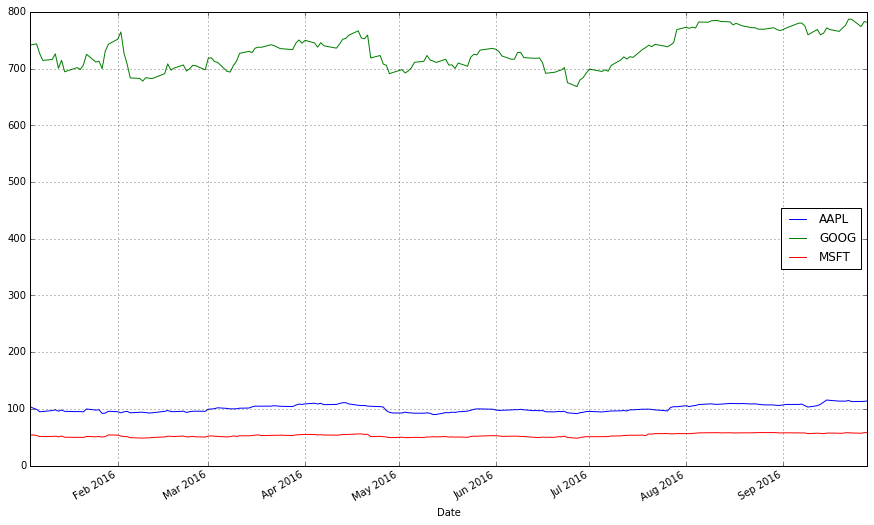

In [10]:
stocks.plot(grid = True)

What’s wrong with this chart? While absolute price is important (pricy stocks are difficult to purchase, which affects not only their volatility but your ability to trade that stock), when trading, we are more concerned about the relative change of an asset rather than its absolute price. Google’s stocks are much more expensive than Apple’s or Microsoft’s, and this difference makes Apple’s and Microsoft’s stocks appear much less volatile than they truly are.

One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

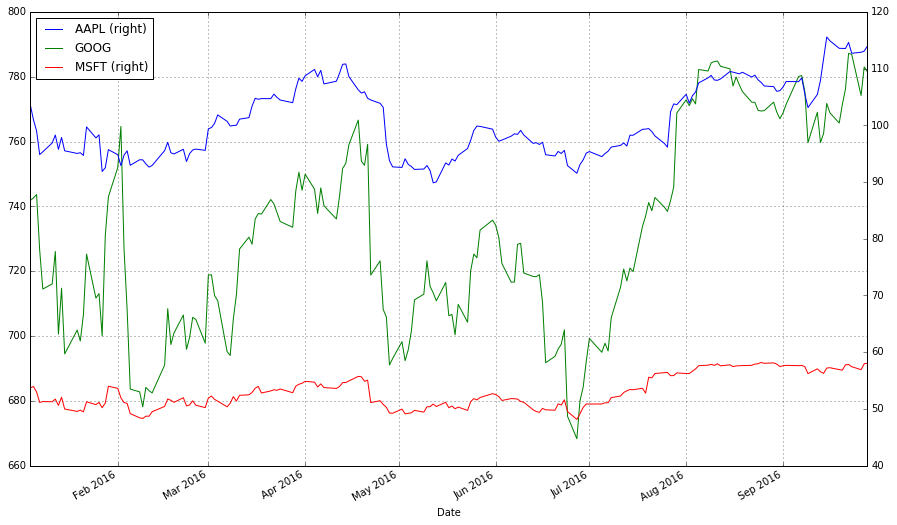

In [12]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply.

One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:

$\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0}$

This will require transforming the data in the stocks object, which I do next.

In [13]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


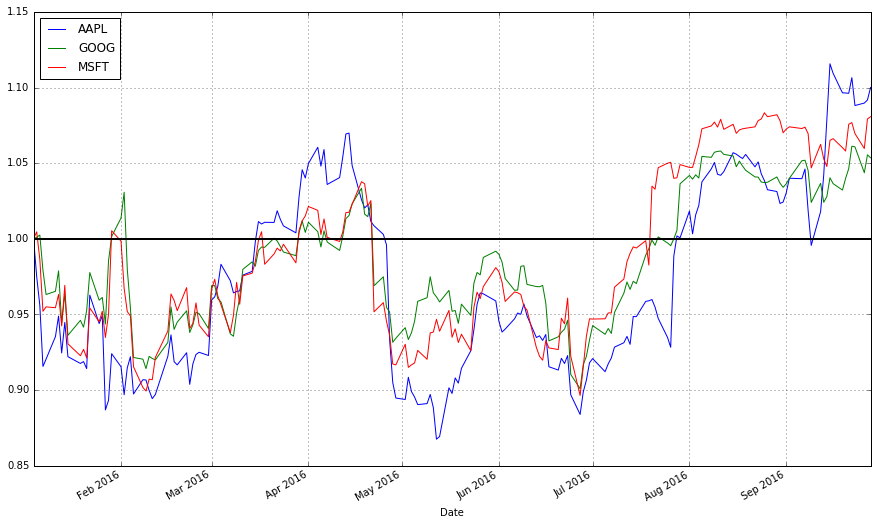

In [14]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts.

Alternatively, we could plot the change of each stock per day. One way to do so would be to plot the percentage increase of a stock when comparing day $t$ to day $t + 1$, with the formula:

$\text{growth}_t = \frac{\text{price}_{t+1} - \text{price}_{t-1}}{\text{price}_t}$

But change could be thought of differently as:

$\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t}$

These formulas are not the same and can lead to differing conclusions, but there is another way to model the growth of a stock: with log differences.

$\text{change}_t = \log(\text{price}_t) - \log(\text{price}_t)$

(Here, $\log$ is the natural log, and our definition does not depend as strongly on whether we use $\log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ or $\log(\text{price}_{t+1}) - \log(\text{price}_{t})$.) The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction.

We can obtain and plot the log differences of the data in stocks as follows:


In [15]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


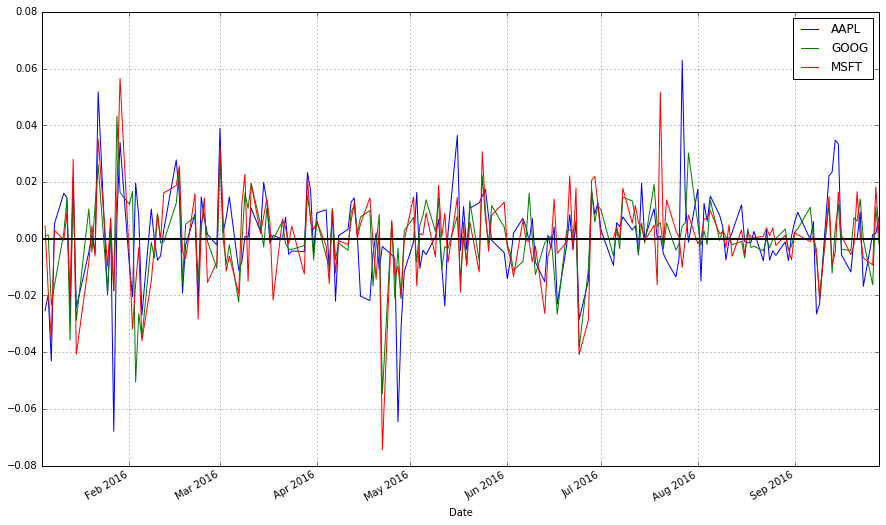

In [16]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Which transformation do you prefer? Looking at returns since the beginning of the period make the overall trend of the securities in question much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

## Moving Averages
Charts are very useful. In fact, some traders base their strategies almost entirely off charts (these are the “technicians”, since trading strategies based off finding patterns in charts is a part of the trading doctrine known as technical analysis). Let’s now consider how we can find trends in stocks.

A q-day moving average is, for a series x_t and a point in time t, the average of the past $q$ days: that is, if $MA^q_t$ denotes a moving average process, then:

$MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}$

Moving averages smooth a series and helps identify trends. The larger q is, the less responsive a moving average process is to short-term fluctuations in the series x_t. The idea is that moving average processes help identify trends from “noise”. Fast moving averages have smaller q and more closely follow the stock, while slow moving averages have larger q, resulting in them responding less to the fluctuations of the stock and being more stable.

pandas provides functionality for easily computing moving averages. I demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

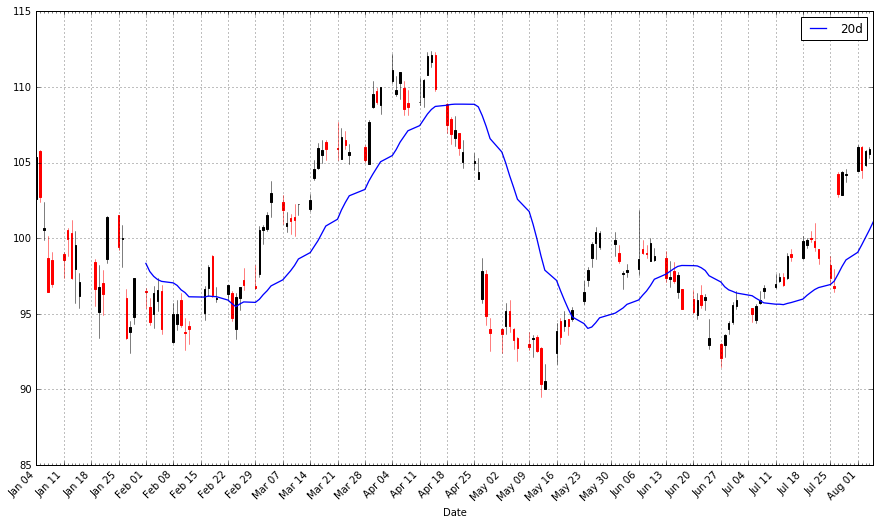

In [17]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

Notice how late the rolling average begins. It cannot be computed until 20 days have passed. This limitation becomes more severe for longer moving averages. Because I would like to be able to compute 200-day moving averages, I’m going to extend out how much AAPL data we have. That said, we will still largely focus on 2016.



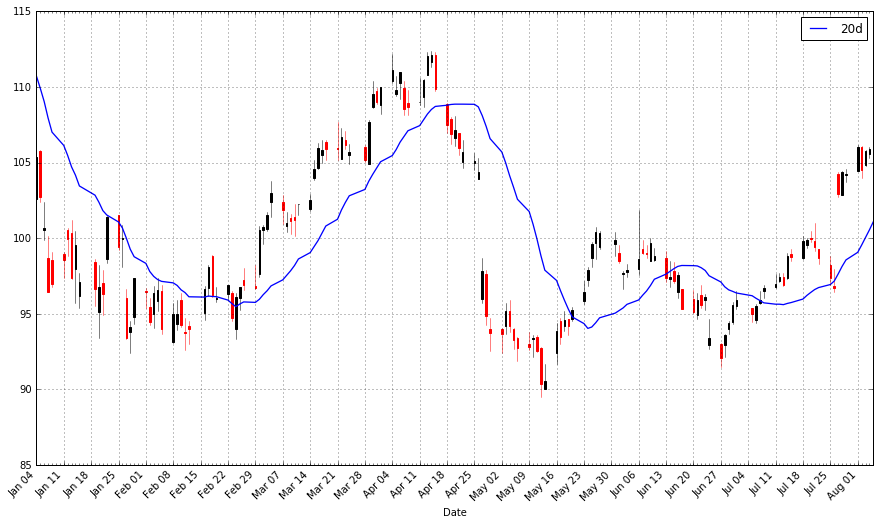

In [18]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

You will notice that a moving average is much smoother than the actual stock data. Additionally, it’s a stubborn indicator; a stock needs to be above or below the moving average line in order for the line to change direction. Thus, crossing a moving average signals a possible change in trend, and should draw attention.

Traders are usually interested in multiple moving averages, such as the 20-day, 50-day, and 200-day moving averages. It’s easy to examine multiple moving averages at once.

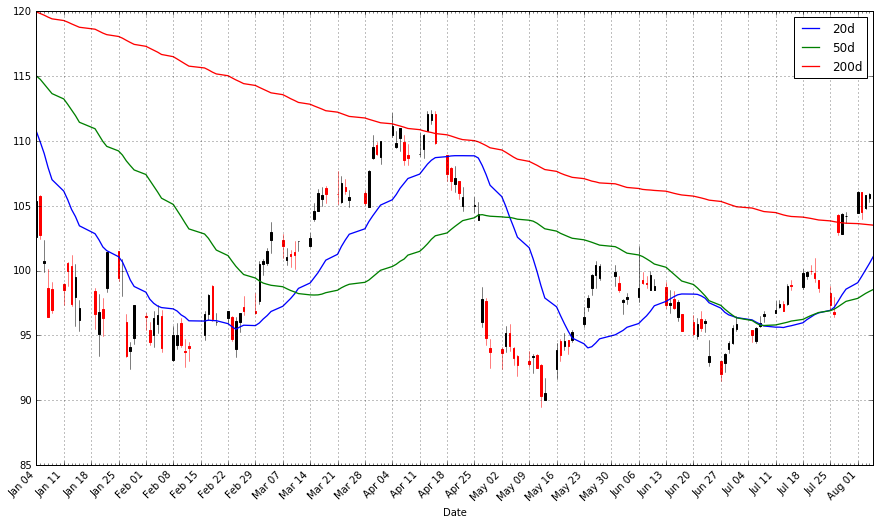

In [19]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

The 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bearish trend: the stock is trending downward over time. The 20-day moving average is at times bearish and at other times bullish, where a positive swing is expected. You can also see that the crossing of moving average lines indicate changes in trend. These crossings are what we can use as trading signals, or indications that a financial security is changing direction and a profitable trade might be made.